# SDFusion: Unconditional generation and shape completion.

In [1]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [2]:
print(os.environ["CUDA_VISIBLE_DEVICES"])

0


In [97]:
# import libraries
import numpy as np
import trimesh
from termcolor import colored, cprint
# for display
from IPython.display import Image as ipy_image
from IPython.display import display

import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from datasets.dataloader import CreateDataLoader, get_data_generator
from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionOpt

seed = 2023
opt = SDFusionOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionTestOption initialized.


In [258]:
# initialize SDFusion model
ckpt_path = './logs_home/2024-11-22T01-51-07-sdfusion-targetaugmented-all-LR1e-4-release/ckpt/df_steps-36000.pth'
dset="targetaugmented"
opt.init_model_args(ckpt_path=ckpt_path)
opt.init_dset_args(dataset_mode=dset)
SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
saved_ckpt/EX03/vqvae_steps-9000.pth
[*] VQVAE: weight successfully load from: saved_ckpt/EX03/vqvae_steps-9000.pth
[*] weight successfully load from: ./logs_home/2024-11-22T01-51-07-sdfusion-targetaugmented-all-LR1e-4-release/ckpt/df_steps-36000.pth
[*] setting ddim_steps=500
[*] Model has been created: SDFusion-Model
[*] "SDFusion-Model" loaded.


## 1. Unconditional Generation

Data shape for DDIM sampling is (2, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:23<00:00, 21.39it/s]


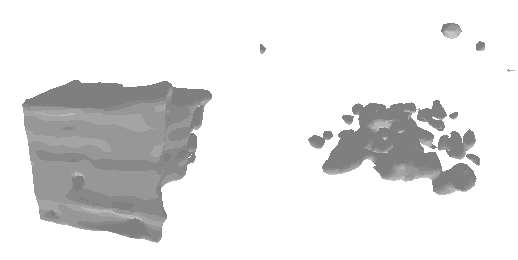

In [269]:
# unconditional generation
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)

ngen = 2
ddim_steps = 500
ddim_eta = 0.0

sdf_gen = SDFusion.uncond(ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta)

mesh_gen = sdf_to_mesh(sdf_gen)
print(mesh_gen)

# vis as gif
gen_name = f'{out_dir}/uncond.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

for name in [gen_name]:
    display(ipy_image(name))

In [270]:
for i, mesh in enumerate(mesh_gen):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results/mesh_{i + 8}.obj")

In [266]:
for i, sdf in enumerate(sdf_gen):
    sdf = np.squeeze(np.asarray(sdf.cpu()))
    INDICES = np.argwhere((-0.025 < sdf) & (sdf < 0.025))
    POINTS = trimesh.voxel.ops.indices_to_points(INDICES)
    MULTIBOX = trimesh.voxel.ops.multibox(POINTS)
    MULTIBOX.apply_scale(1.0 / 64)
    MULTIBOX.export(f"demo_results/mesh_{i + 8}_multibox.obj")

## 2. Shape Completion

We first prepare the input shape here. Use the xyz range `(-1 ~ 1)` to specify the missing region `(x_min, x_max, y_min, y_max, z_min, z_max)`.
The orientations are (suppose we look at the shape):
- x: left to right
- y: bottom to top
- z: back to front

For instance, setting `y_min, y_max = 0, 1` gives us the top half of the shape.

In [160]:
# initialize dataset
# dataroot = '/data01/data'
dset = 'targetaugmented'
opt.init_dset_args(dataset_mode=dset)
_, test_dl, _ = CreateDataLoader(opt)
test_ds = test_dl.dataset
test_dg = get_data_generator(test_dl)

64
[*] 1140 samples loaded.
64
[*] 1140 samples loaded.
[*] Dataset has been created: TargetAugmented-64


In [239]:
for i, test_data in enumerate(test_ds):
    if test_data['path'] == 'data/TARGETAUGMENTED/SDF/resolution_64/Doesburg_MaisonD’artiste_Master3D__Stofft_Leon_0/ori_sample_grid.h5':
        print(i)

375


{'sdf': tensor([[[[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          ...,
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]],

         [[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          ...,
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000]],

         [[0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
          [0.2000, 0.2000, 0.2000,

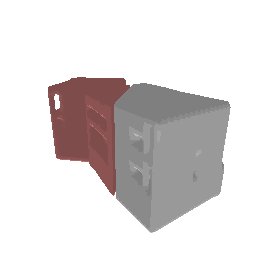

Red cuboid: missing region


In [240]:
from utils.demo_util import get_partial_shape
from utils.util_3d import combine_meshes

# 987: sofa
data_ix = 0
test_data = test_ds[data_ix]
print(test_data)

shape = test_data['sdf'].unsqueeze(0).to(device)

# specify input range. [min, max]: [-1, 1]
# default setting: given top shape.
x_min, x_max = 0, 1
y_min, y_max = -1, 1
z_min, z_max = -1, 1
xyz_dict = {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (z_min, z_max)}

# visualize input and partial shape
ret = get_partial_shape(shape, xyz_dict)
shape_part, shape_missing = ret['shape_part'], ret['shape_missing']

mesh_part = sdf_to_mesh(shape_part)
mesh_missing = sdf_to_mesh(shape_missing, color=[1, .6, .6])

# print(mesh_part)
# print(mesh_missing)

mesh_comb = combine_meshes(mesh_part, mesh_missing)
print(len(mesh_comb))
# rend_mesh_comb = render_mesh(SDFusion.renderer, mesh_comb, norm=False)

# save it
out_dir = 'demo_results'
if not os.path.exists(out_dir): os.makedirs(out_dir)
sc_input_name = f'{out_dir}/shape_comp_input.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_comb, nrow=3, out_name=sc_input_name)

for name in [sc_input_name]:
    display(ipy_image(name))

print('Red cuboid: missing region')

In [189]:
import trimesh

for i, mesh in enumerate(mesh_part):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results/mesh_180_inp.obj")

Data shape for DDIM sampling is (6, 3, 16, 16, 16), eta 0.0
Running DDIM Sampling with 500 timesteps


DDIM Sampler: 100%|██████████| 500/500 [00:59<00:00,  8.45it/s]


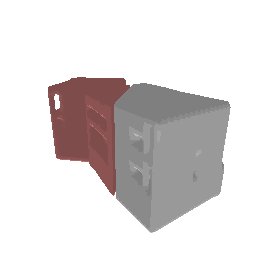

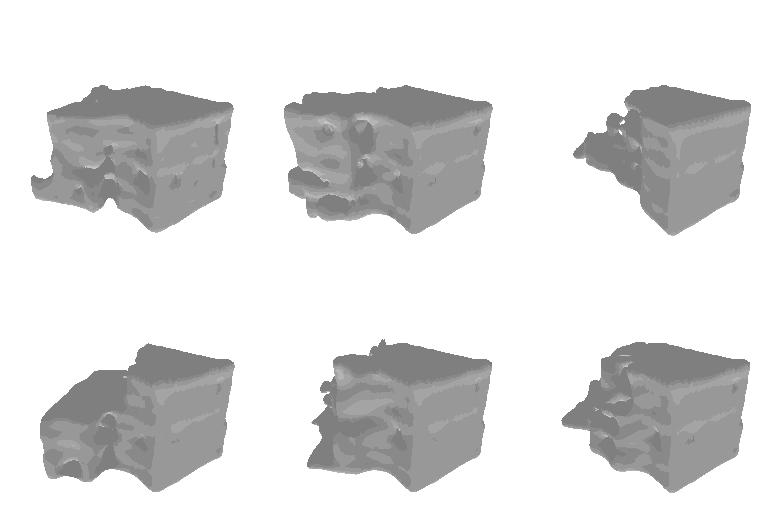

[*] Red cuboid: missing region


In [190]:
# shape completion
ngen = 6
ddim_steps = 500
ddim_eta = 0.
output_shape_comp = SDFusion.shape_comp(shape, xyz_dict, ngen=ngen, ddim_steps=ddim_steps, ddim_eta=ddim_eta)

mesh_shape_comp = sdf_to_mesh(output_shape_comp)

# vis as gif
sc_output_name = f'{out_dir}/shape_comp_output.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_shape_comp, nrow=3, out_name=sc_output_name)

for name in [sc_input_name, sc_output_name]:
    display(ipy_image(name))

print('[*] Red cuboid: missing region')

In [182]:
import trimesh

for i, mesh in enumerate(mesh_shape_comp):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results/mesh_180_out.obj")

In [191]:
import trimesh

for i, mesh in enumerate(mesh_shape_comp):
    verts = mesh.cpu().verts_list()
    faces = mesh.cpu().faces_list()
    
    mesh_trimesh = trimesh.Trimesh(np.asarray(verts[0]), np.asarray(faces[0]))
    mesh_trimesh.export(f"demo_results//mesh_180_out_{i}.obj")